<div style="display:flex;flex-direction:column;align-items:center;justify-content:center;padding:22px 0 8px;background:linear-gradient(180deg,rgba(103, 57, 228, 1),transparent);">
  <h1 style="margin:0;font-family:'Segoe UI', Roboto, Helvetica, Arial, sans-serif;color:#e8eced;font-size:40px;letter-spacing:-0.5px;"><b>LLM Benchmark & Evaluation</b></h1>
  <p style="margin:8px 0 0;color:#e8eced;font-size:15px;max-width:900px;text-align:center;">Exploring benchmarks, evaluation metrics, and insights to measure and compare large language models effectively.</p>
  <div style="margin-top:12px;display:flex;gap:8px;flex-wrap:wrap;justify-content:center;">
    <span style="background:#eef2ff;color:#3730a3;padding:6px 12px;border-radius:999px;font-size:12px;font-weight:600;">Benchmarking</span>
    <span style="background:#ecfeff;color:#045e66;padding:6px 12px;border-radius:999px;font-size:12px;font-weight:600;">Metrics</span>
    <span style="background:#fff7ed;color:#92400e;padding:6px 12px;border-radius:999px;font-size:12px;font-weight:600;">Evaluation</span>
  </div>
</div>

<style>
  .notebook-title-decor {height:8px;background:linear-gradient(90deg,#7c3aed,#06b6d4);border-radius:6px;margin:16px 0 22px;max-width:720px;margin-left:auto;margin-right:auto}
</style>
<div class="notebook-title-decor"></div>

##  [&#9650;](#toc0_) <a id='toc1_1_'></a>**Introduction**

This notebook explores benchmarks and evaluation metrics for our Graph Rag model.
It provides an insight on: 

- Query examples
- accuracy metrics
- latency plots

Use the sections below to run experiments, visualize results, and capture insights.

**Table of contents**<a id='toc0_'></a>    
- [**Introduction**](#toc1_1_)    
- [**Query Examples**](#toc2_)    
  - [Build a Session](#toc2_1_)    
  - [Ask Questions](#toc2_2_)    
- [**Benchmarks**](#toc3_)    
  - [Result](#toc3_1_)    
    - [Metrics](#toc3_1_1_)    
    - [Latency](#toc3_1_2_)    
  - [Conclusion](#toc3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=3
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

---
#  [&#9650;](#toc0_) <a id='toc2_'></a>**Query Examples**

Let's do a small test on four PDF files:
- [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
- [Attention Is Not All You Need Anymore](https://arxiv.org/abs/2308.07661)
- [Attention is not Explanation](https://arxiv.org/abs/1902.10186)
- [On the rheology of cats](https://www.drgoulu.com/wp-content/uploads/2017/09/Rheology-of-cats.pdf)

The pipeline use below is the pipeline reproduced in the app.
For more information on it check `README.md`.

In [1]:
from requests import request
from src.graph_rag.config import settings

Check the settings:

In [2]:
attribute =  [
    "data_dir", 
    "ollama_base_url", "ollama_chat_model", "ollama_extraction_model", "ollama_embedding_model", 
    "chroma_db_dir", 
    "max_sources_per_use_case", "min_relevance_score", "source_preview_chars", "usecase_graph_dir", "usecase_vector_prefix", 
    "max_neighbors_per_entity", "graph_store_path", 
    "extraction_max_concurrency", "extraction_batch_size", "extraction_debug_samples", "max_graph_paths_per_answer"]

print("Current Settings:")
print("-----------------")
for setting in attribute:
    print(f"{setting:<30}: {getattr(settings, setting)}")

Current Settings:
-----------------
data_dir                      : data\raw
ollama_base_url               : http://localhost:11434
ollama_chat_model             : llama3
ollama_extraction_model       : llama3
ollama_embedding_model        : nomic-embed-text
chroma_db_dir                 : chroma_db
max_sources_per_use_case      : 12
min_relevance_score           : 0.1
source_preview_chars          : 1500
usecase_graph_dir             : graph_sessions
usecase_vector_prefix         : graphrag_usecase_
max_neighbors_per_entity      : 10
graph_store_path              : graph_store.json
extraction_max_concurrency    : 8
extraction_batch_size         : 8
extraction_debug_samples      : 0
max_graph_paths_per_answer    : 5


##  [&#9650;](#toc0_) <a id='toc2_1_'></a>Build a Session

To build a session we can pass two parameters:
- `brief`: that will help the model to select the important source to avoid building a graph on all our data (which can be pretty long). It doesn't affect the knowledge graph itself.
- `max_sources`: which is the number of source the model will kept

Let's first pass on all our data, thus the brief doesn't matter.

In [3]:
headers = {"Content-Type": "application/json"}
payload = {
    'brief': 'A knowledge graph on all our data',
    'max_sources': 4,
}
r = request("POST", f"http://localhost:8000/use_case/build", headers=headers, json=payload).json()
r

{'session_id': 'b6cd94d1-a57d-4e9b-bef4-bdf6e5a0ad05',
 'brief': 'A knowledge graph on all our data',
 'num_sources': 4,
 'num_chunks': 77,
 'selected_sources': [{'path': 'data\\raw\\Attention_is_all_you_need.pdf',
   'score': 0.3125573410612118,
   'overlap': 0.0,
   'embedding_score': 0.5209289017686863,
   'preview': 'Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nG'},
  {'path': 'data\\raw\\Attention_is_not_all_you_need_anymore.pdf',
   'score': 0.27924743334935953,
   'overlap': 0.0,
   'embedding_score': 0.4654123889155993,
   'preview': 'Attention Is Not All You Need Anymore\nZhe Chen\nSchool of Computer Science and 

As we can see, these results are expected given the generic brief *'A knowledge graph on all our data'*.

- `Embedding score`: semantic similarity between the brief and each document (values ~0.41–0.52 here).
- `Overlap`: lexical overlap is 0.0 because the brief is very generic, and the preview texts do not share the same long tokens (>3 chars) after the simple token filter. So no keyword matches were found.
- `Selection score`: calculated as $0.6 * \textrm{embedding score} + 0.4 * \textrm{overlap}$. With overlap=0, the final score is $\approx 0.6 * \textrm{embedding score}$.

##  [&#9650;](#toc0_) <a id='toc2_2_'></a>Ask Questions

In [7]:
payload = {
    'session_id': r.get('session_id'),
    'question': "What is Attention, and when should it be used?",
}
answ = request("POST", f"http://localhost:8000/use_case/qa", headers=headers, json=payload).json()
answ

{'answer': 'Based on the provided graph context, it appears that you are asking about attention and when to use it. Attention is a mechanism used in deep learning models, particularly in natural language processing (NLP) tasks, such as machine translation, question answering, and text summarization.\n\nAttention allows the model to focus on specific parts of the input data that are relevant for making predictions or generating outputs. In other words, attention helps the model to selectively attend to certain tokens, words, or phrases in a sequence, rather than considering all of them equally.\n\nThere are different types of attention mechanisms, including:\n\n1. **Self-Attention**: This type of attention is used within a single sequence (e.g., a sentence) to focus on specific parts of the input.\n2. **Cross-Attention**: This type of attention is used between two sequences (e.g., a source and target language) to align relevant information.\n\nWhen to use attention:\n\n1. **Sequence-to-

In [8]:
print(answ["answer"])

Based on the provided graph context, it appears that you are asking about attention and when to use it. Attention is a mechanism used in deep learning models, particularly in natural language processing (NLP) tasks, such as machine translation, question answering, and text summarization.

Attention allows the model to focus on specific parts of the input data that are relevant for making predictions or generating outputs. In other words, attention helps the model to selectively attend to certain tokens, words, or phrases in a sequence, rather than considering all of them equally.

There are different types of attention mechanisms, including:

1. **Self-Attention**: This type of attention is used within a single sequence (e.g., a sentence) to focus on specific parts of the input.
2. **Cross-Attention**: This type of attention is used between two sequences (e.g., a source and target language) to align relevant information.

When to use attention:

1. **Sequence-to-sequence tasks**: Atten

In [9]:
print(list(set([s["source"] for s in answ["citations"]])))

['data\\raw\\Attention_is_not_explanation.pdf', 'data\\raw\\Attention_is_not_all_you_need_anymore.pdf', 'data\\raw\\Attention_is_all_you_need.pdf']


We have a really good answer based on the right data! And as we can see our model didn't use *On the rheology of cat* to answer which is a good thing.

In [23]:
from pyvis.network import Network
from IPython.display import IFrame, display

# Extract graph data from the answer (safe access)
graph_data = answ.get("graph_context") if isinstance(answ, dict) else None
if not graph_data:
    raise ValueError("No graph_context found in response")

nodes = graph_data.get("nodes", [])
edges = graph_data.get("edges", [])

net = Network(notebook=True, cdn_resources='remote')

# Add nodes
for node in nodes:
    nid = node.get("id")
    label = node.get("name") or node.get("id")
    title = str(node.get("properties", "") or node.get("description", ""))
    net.add_node(nid, label=label, title=title)

# Add edges
for edge in edges:
    src = edge.get("source")
    tgt = edge.get("target")
    lbl = edge.get("type") or edge.get("relationship", "")
    net.add_edge(src, tgt, label=lbl)

# Generate HTML and write using UTF-8 to avoid Windows cp1252 errors
html = net.generate_html()
with open("graph.html", "w", encoding="utf-8") as f:
    f.write(html)

# Display interactive graph in the notebook
display(IFrame("graph.html", width=900, height=600))

In [24]:
payload = {
    'session_id': r.get('session_id'),
    'question': "Can cat considered liquid?",
}
answ = request("POST", f"http://localhost:8000/use_case/qa", headers=headers, json=payload).json()
answ

{'answer': 'What a delightful and absurd paper!\n\nWhile cats are not typically considered liquids, the author of this paper takes a humorous approach to exploring the rheological properties of Felis catus (the domestic cat). The text is filled with witty remarks, clever analogies, and playful references to scientific concepts.\n\nIn the context of graph theory, I\'d say that the nodes in this graph represent different ideas, concepts, or themes related to the rheology of cats. The edges connecting these nodes could represent relationships between these ideas, such as "cats are liquids" → "surface tension" → "yield stress".\n\nSome notable nodes in this graph include:\n\n1. "Cats are liquids": This node represents the central claim of the paper, which is that cats can be considered liquids in certain contexts.\n2. "Surface tension": This node connects to the idea that cats have a surface tension similar to water droplets bouncing on hydrophobic substrates.\n3. "Yield stress": This node

In [25]:
print(answ["answer"])

What a delightful and absurd paper!

While cats are not typically considered liquids, the author of this paper takes a humorous approach to exploring the rheological properties of Felis catus (the domestic cat). The text is filled with witty remarks, clever analogies, and playful references to scientific concepts.

In the context of graph theory, I'd say that the nodes in this graph represent different ideas, concepts, or themes related to the rheology of cats. The edges connecting these nodes could represent relationships between these ideas, such as "cats are liquids" → "surface tension" → "yield stress".

Some notable nodes in this graph include:

1. "Cats are liquids": This node represents the central claim of the paper, which is that cats can be considered liquids in certain contexts.
2. "Surface tension": This node connects to the idea that cats have a surface tension similar to water droplets bouncing on hydrophobic substrates.
3. "Yield stress": This node relates to the concept

In [27]:
print(list(set([s["source"] for s in answ["citations"]])))

['data\\raw\\Rheology-of-cats.pdf']


The answer is not best but is still good.<br>
The problem is that the model is too conscious that it is given a graph and needs to work with this graph.

Otherwise, we get a pretty clean and clear answer on the different notion and properties of the cat than can make them look like liquid.

Let's test our model selection by reducing the number of sources with a specific brief to see if it manages to take the three good answer.

In [28]:
headers = {"Content-Type": "application/json"}
payload = {
    'brief': 'Information on Attention in the litterature',
    'max_sources': 3,
}
r = request("POST", f"http://localhost:8000/use_case/build", headers=headers, json=payload).json()
r

{'session_id': '7348c416-e078-447a-ae57-e8afb452549d',
 'brief': 'Information on Attention in the litterature',
 'num_sources': 3,
 'num_chunks': 69,
 'selected_sources': [{'path': 'data\\raw\\Attention_is_not_all_you_need_anymore.pdf',
   'score': 0.4152653122695793,
   'overlap': 0.3333333333333333,
   'embedding_score': 0.4698866315604099,
   'preview': 'Attention Is Not All You Need Anymore\nZhe Chen\nSchool of Computer Science and Engineering\nNortheastern University\nShenyang, Liaoning, China\nml_iot@163.com; chenzhe@mail.neu.edu.cn\nAbstract\nIn recent years, the popular Transformer architecture has achieved great success in many application\nareas, including natural language processing and computer vision. Many existing works aim to reduce\nthe comput'},
  {'path': 'data\\raw\\Attention_is_all_you_need.pdf',
   'score': 0.41107620874538064,
   'overlap': 0.3333333333333333,
   'embedding_score': 0.4629047923534122,
   'preview': 'Provided proper attribution is provided, Google 

Indeed we don't get the paper on cats, and only got the ones related to attention.

In [31]:
payload = {
    'session_id': r.get('session_id'),
    'question': "Can cat considered liquid?",
}
answ = request("POST", f"http://localhost:8000/use_case/qa", headers=headers, json=payload).json()
print(answ["answer"])

No, cats cannot be considered liquids. Cats are living creatures that belong to the class Mammalia and order Carnivora. They have a solid body made up of bones, muscles, organs, and skin, which is very different from the physical properties of liquids.

In physics, a liquid is defined as a state of matter characterized by a fixed volume but no fixed shape, where particles are close together but still able to flow freely. Liquids have certain properties such as viscosity, surface tension, and density that distinguish them from solids and gases.

Cats, on the other hand, do not possess these properties. They are solid objects with a specific shape and volume, and their physical behavior is governed by different laws than those of liquids. So, it's not possible to consider cats as liquids.


Our model answer completely differs from the previous one.

However, the answer that we would have preferred was that it doesn't know how to answer.<br>
This is also because the answer is too generic.

In [35]:
payload = {
    'session_id': r.get('session_id'),
    'question': "Can you tell me a little more about the game Clair Obscur: Expedition 33?",
}
answ = request("POST", f"http://localhost:8000/use_case/qa", headers=headers, json=payload).json()
print(answ["answer"])

I see you're interested in learning more about the game Clair Obscur: Expedition 33. Unfortunately, I have to inform you that there is no such game as Clair Obscur: Expedition 33.

The text you provided appears to be a collection of passages from various sources, including academic papers and online articles. The topics discussed include attention mechanisms in neural networks, feature importance measures, and transformer models.

If you're interested in learning more about these topics or exploring related research areas, I'd be happy to help you find relevant resources or provide an overview of the concepts. Just let me know!


That's the answer we expect !<br>
Even tho it doesn't seem to be really consistent.

Those test were made using **llama3**.

We tried to use **Gpt-oss:20B** and we get much more accurate and consistent answer during our small test.<br>
However, we lost a little bit in latency.

Now let's try it on a real benchmark.

#  [&#9650;](#toc0_) <a id='toc3_'></a>**Benchmarks**

We are going to use the [Ragas](https://docs.ragas.io/en/stable/getstarted/quickstart/)' framework which offer a good and simple way to test our model.

For the benchmark we chose to use [GraphRAG-Bench](https://github.com/GraphRAG-Bench/GraphRAG-Benchmark/tree/main#leaderboards) with four level of complexity: 
- **Level 1**: **Fact Retrieval** *Example: "Which region of France is Mont St. Michel located?"*
- **Level 2**: **Complex Reasoning** *Example: "How did Hinze's agreement with Felicia relate to the perception of England's rulers?"*
- **Level 3**: **Contextual Summarization** *Example: "What role does John Curgenven play as a Cornish boatman for visitors exploring this region?"*
- **Level 4**: **Creative Generation** *Example: "Retell King Arthur's comparison to John Curgenven as a newspaper article."*

Because it will take too long to go through all the question, we chose to only go through a sample of it. The sample is composed of 25% of the question chosen randomly.<br>
Moreover, indexing everytime a new graph would also add tremendous time to our test that is not even imaginable with our resources.<br>
Thus, we chose to index our full dataset (the 21 sources) and evaluate only how it responds.

It took about **199 min 4.9s to index the entire dataset** (Novels + Medical).

The test is composed of two phases:

- **Phase 1 (Query)**: the runner retrieves and generates answers for every question only, no grading yet. Responses are saved (and checkpointed to a CSV) along with per-item query timing and minimal logs; this keeps the heavy model work isolated and repeatable so we can re-run grading later without redoing generation.
- **Phase 2 (Grading)**: the runner reads the checkpointed answers and runs the classifier to assign labels (coverage, grounding, faithfulness, relevancy). Grading runs with its own concurrency limits and backoff logic to avoid VRAM contention; final rows include query + grade latencies and the combined per-item total.

It took around **7 hours** to go through the **entire sample** (735 questions).

In [3]:
headers = {"Content-Type": "application/json"}
r = request("POST", f"http://localhost:8000/build_index", headers=headers).json()
r

{'num_sources': 21,
 'num_chunks': 2906,
 'sources': ['D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Medical.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-10146.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-10321.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-10356.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-10762.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-2544.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-25646.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-26183.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-29973.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-30752.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-40700.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-4128.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-41603.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-44557.txt',
  'D:\\VSCode_ws\\llm_genai_pr

You then just needs to run the `evals.py` file. The result will appear in the form of a .csv in the experiments folder.

In [4]:
r

{'num_sources': 21,
 'num_chunks': 2906,
 'sources': ['D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Medical.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-10146.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-10321.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-10356.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-10762.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-2544.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-25646.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-26183.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-29973.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-30752.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-40700.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-4128.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-41603.txt',
  'D:\\VSCode_ws\\llm_genai_project\\data\\raw\\Novel-44557.txt',
  'D:\\VSCode_ws\\llm_genai_pr

In [4]:
import pandas as pd

df = pd.read_csv("rag_eval/evals/experiments/test_dataset_results.csv")

In [5]:
df.head()

,answer_relevancy,conciseness,coverage,evidence,evidence_triples,faithfulness,grade_latency_s,grading_notes,grounding,log_file,query_latency_s,question,response,total_latency_s
0,unknown,concise,unknown,Mont St. Michel is located in Normandy.,"(Mont St. Michel,was in,Normandy)",unknown,70.3294,Normandy,unknown,D:\VSCode_ws\llm_genai_project\rag_eval\evals\...,20.0835,According to the narrative's discussion of his...,I see you're asking about the region of France...,90.4129
1,on-topic,concise,low,Henry de la Pomeroy caused himself to be bled ...,"(Henry de la Pomeroy,caused himself to be bled...",unfaithful,3.7166,Henry de la Pomeroy,hallucinated,D:\VSCode_ws\llm_genai_project\rag_eval\evals\...,21.6734,In the historical account relating to St. Mich...,The individual said to have been killed in the...,25.3900
2,off-topic,verbose,low,Asparagus Island is located near or within Kyn...,"(Kynance Cove,is located near,Asparagus Island...",unfaithful,2.6986,"Asparagus Island, Gull Rock, and Bellows",hallucinated,D:\VSCode_ws\llm_genai_project\rag_eval\evals\...,5.7518,In the account of the travelers' visit to Kyna...,It looks like you have a large collection of t...,8.4504
3,unknown,concise,low,Uther Pendragon fell in love with Ygrayne.,"(Uther Pendragon, fell in love with, Ygrayne)",unfaithful,19.0483,Uther Pendragon fell in love with Ygrayne.,hallucinated,D:\VSCode_ws\llm_genai_project\rag_eval\evals\...,7.0952,In the context of the Arthurian story as recou...,"I'm happy to help! However, I have to say that...",26.1435
4,unknown,concise,unknown,Charles is the driver of the carriage.,"(driver,is,Charles)",unknown,41.1176,Charles is the driver of the carriage.,unknown,D:\VSCode_ws\llm_genai_project\rag_eval\evals\...,7.0048,"During the journey through Cornwall, who drove...","According to the text, it was not specified wh...",48.1224


**Unknown labels** occur when the grader can’t extract valid labels from the model output.<br> 
Either the model doesn’t follow the expected format, the response is truncated/malformed, or our tolerant parsing still can’t match allowed values—so we fall back to "unknown".

In the unknown returns, almost all are caused by empty answers.

Grading runs a small classifier that reads each generated answer and maps it to four strict labels (coverage, grounding, faithfulness, relevancy) using a constrained prompt and tolerant parsing; we attempt retries and small parsing fallbacks (regex, normalization) before returning a label.<br>
Empty answers occur for two main reasons: 
1. **the grader model sometimes produces malformed or truncated output** that our parser can’t interpret, so we mark it "unknown"
2. **resource overload on the local LLM host** (VRAM/KV‑cache exhaustion) causes fast failures or empty responses—these are transient allocation errors that return no usable text and trigger our retry/backoff logic. 

A solution would be reducing concurrent grading, and adding longer, jittered backoff significantly reduce empty outputs and increase successful label extraction.

However, it would at the strict minimum double the time taken for grading.<br>
Being that limited, we chose to overlook this problem.

For a small comparison, the first runs we did take 2h but had between 80 and 90% of unknowns. Reduced it by half this percentage more than triple the time of grading.

##  [&#9650;](#toc0_) <a id='toc3_1_'></a>Result

###  [&#9650;](#toc0_) <a id='toc3_1_1_'></a>Metrics

We have 5 mains metrics:
- **Coverage**: how much of the required evidence the answer includes (*high/partial/low*); 
- **Grounding**: whether the answer is supported by retrieved sources or is a hallucination; 
- **Faithfulness**: whether the answer accurately reflects the source content; 
- **Answer relevancy**: how on‑topic the answer is to the question (*on‑topic/partial/off‑topic*); 
- **Conciseness**: the answer's verbosity (*terse/concise/verbose*).

Overall Evaluation Metrics Summary

COVERAGE:
  - unknown        :   40.1%
  - low            :   29.5%
  - high           :   23.9%
  - partial        :    6.4%

GROUNDING:
  - unknown        :   45.2%
  - hallucinated   :   30.2%
  - grounded       :   24.6%

FAITHFULNESS:
  - unknown        :   47.6%
  - unfaithful     :   27.8%
  - faithful       :   24.6%

ANSWER_RELEVANCY:
  - unknown        :   50.2%
  - on-topic       :   23.9%
  - off-topic      :   19.9%
  - partial        :    6.0%

CONCISENESS:
  - verbose        :   63.9%
  - concise        :   35.2%
  - terse          :    0.8%


C:\Users\Jules\AppData\Local\Temp\ipykernel_4916\2200834174.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


<Figure size 1200x800 with 0 Axes>

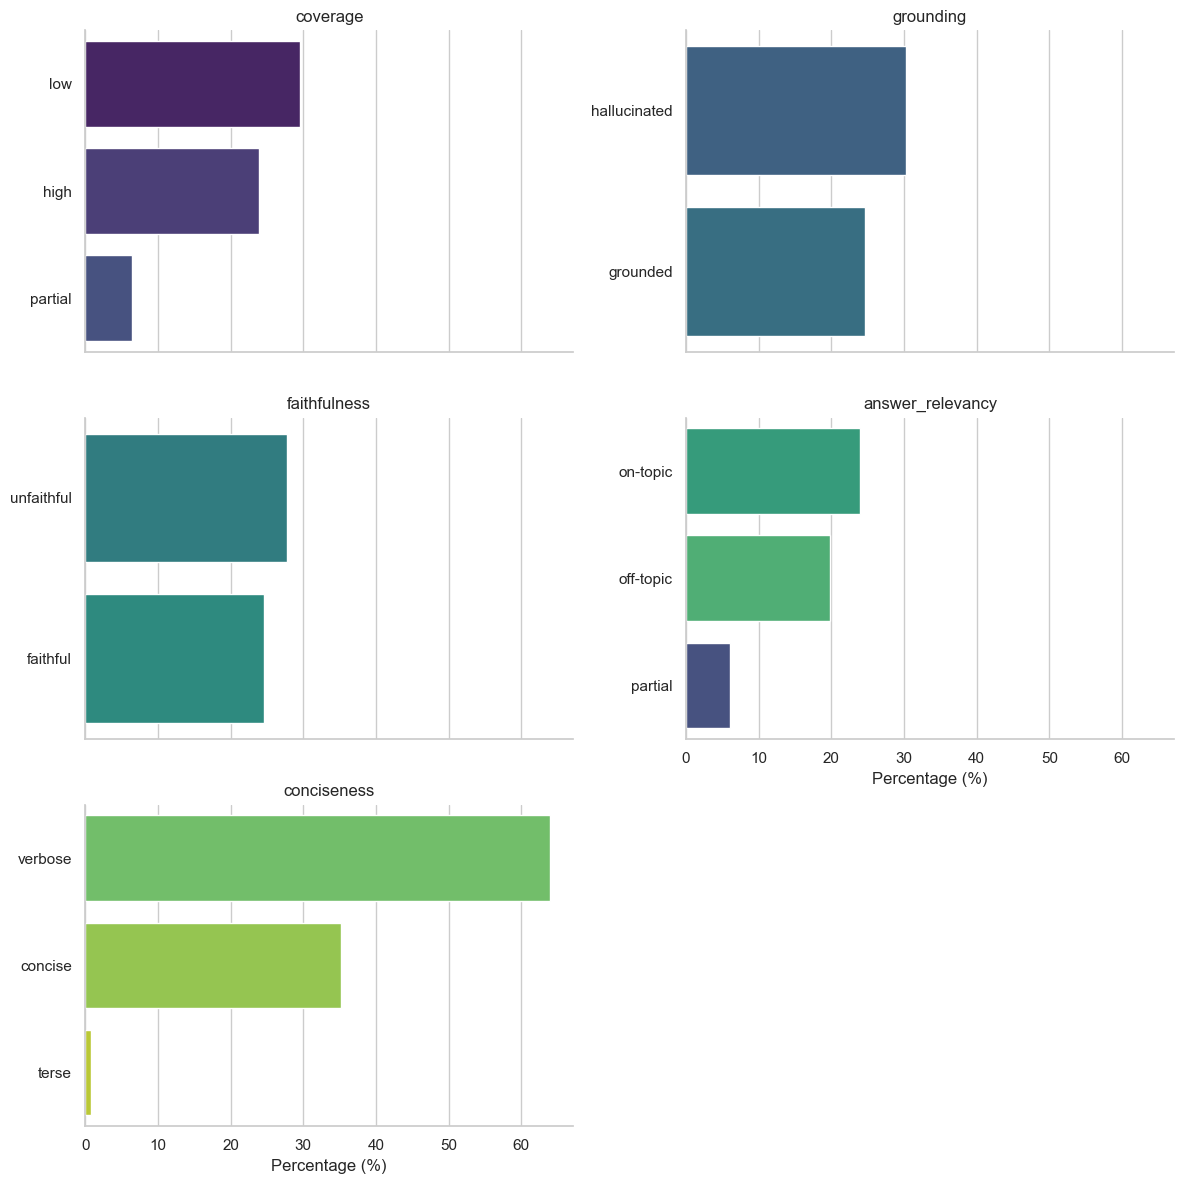

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results
df = pd.read_csv("rag_eval/evals/experiments/test_dataset_results.csv")

# Define the metrics we want to summarize
metrics = ["coverage", "grounding", "faithfulness", "answer_relevancy", "conciseness"]

print("Overall Evaluation Metrics Summary")
print("=" * 40)

summary_data = []

for metric in metrics:
    if metric in df.columns:
        counts = df[metric].value_counts(normalize=True) * 100
        print(f"\n{metric.upper()}:")
        for label, pct in counts.items():
            print(f"  - {label:<15}: {pct:>6.1f}%")
            summary_data.append({"Metric": metric, "Label": label, "Percentage": pct})

# Create a visualization
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Filter out 'unknown' if present for cleaner plots
plot_df = pd.DataFrame(summary_data)
plot_df = plot_df[plot_df["Label"] != "unknown"]

g = sns.catplot(
    data=plot_df, kind="bar",
    x="Percentage", y="Label", col="Metric",
    col_wrap=2, palette="viridis", height=4, aspect=1.5,
    sharey=False
)

g.set_axis_labels("Percentage (%)", "")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()

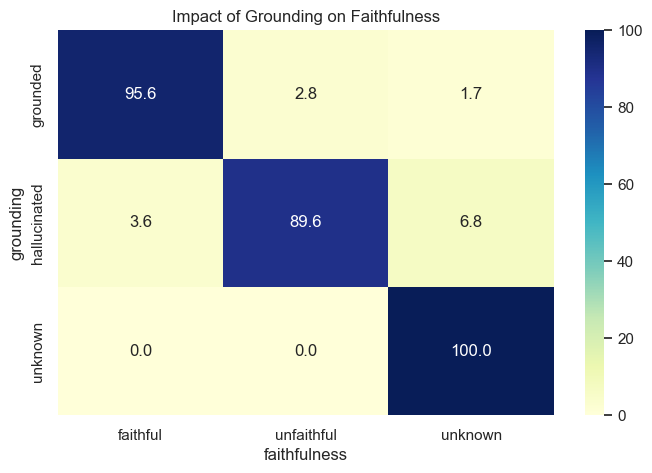


Conciseness vs Grounding (%)
grounding     grounded  hallucinated    unknown
conciseness                                    
concise      22.779923     32.818533  44.401544
terse        66.666667     33.333333   0.000000
verbose      25.106383     28.723404  46.170213

Number of Critical Failures: 194

Sample Critical Failures:


,question,response
1,In the historical account relating to St. Mich...,The individual said to have been killed in the...
2,In the account of the travelers' visit to Kyna...,It looks like you have a large collection of t...
3,In the context of the Arthurian story as recou...,"I'm happy to help! However, I have to say that..."
6,According to the journey through coastal villa...,I see you've provided a large block of text fr...
7,Which beach did Charles suggest visiting for s...,"I'm happy to help! However, I must point out t..."



Overall Pipeline Success Rate: 23.3%


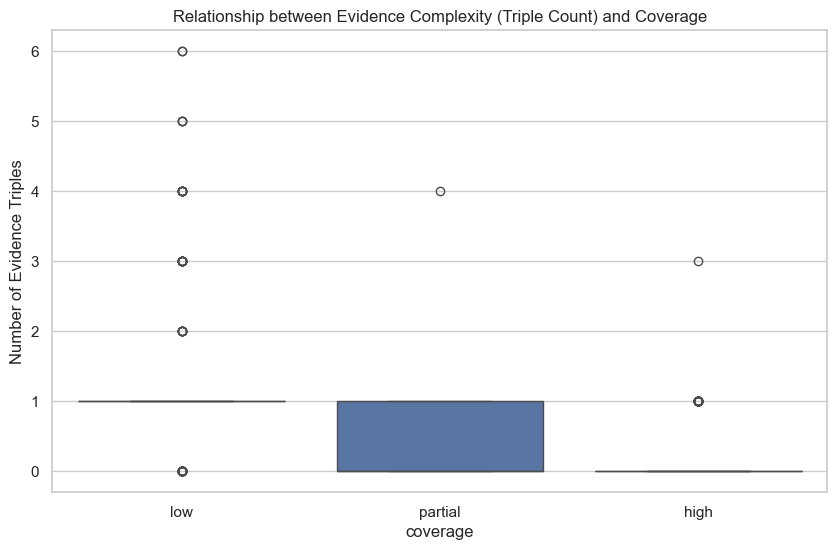


Average triples for successful answers: 0.17
Average triples for failed answers: 0.85


In [7]:
# 1. Correlation between Grounding and Faithfulness
# Do hallucinated answers tend to be unfaithful to the source?
ct = pd.crosstab(df['grounding'], df['faithfulness'], normalize='index') * 100

plt.figure(figsize=(8, 5))
sns.heatmap(ct, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Impact of Grounding on Faithfulness")
plt.show()

# 2. Impact of Conciseness on Quality
# Are verbose answers more likely to hallucinate?
concise_grounding = pd.crosstab(df['conciseness'], df['grounding'], normalize='index') * 100
print("\nConciseness vs Grounding (%)")
print(concise_grounding)

# 3. Identifying "Critical Failures"
# Questions where grounding is 'hallucinated' AND coverage is 'low'
critical_failures = df[(df['grounding'] == 'hallucinated') & (df['coverage'] == 'low')]
print(f"\nNumber of Critical Failures: {len(critical_failures)}")
if len(critical_failures) > 0:
    print("\nSample Critical Failures:")
    display(critical_failures[['question', 'response']].head(5))

# 4. Success Rate by Metric
# We define 'Success' as Grounded, Faithful, and High/Partial Coverage
df['is_success'] = (
    (df['grounding'] == 'grounded') & 
    (df['faithfulness'] == 'faithful') & 
    (df['coverage'].isin(['high', 'partial']))
)
success_rate = df['is_success'].mean() * 100
print(f"\nOverall Pipeline Success Rate: {success_rate:.1f}%")

# 5. Evidence Complexity vs. Quality
# Does having more evidence triples lead to better coverage?
df['triple_count'] = df['evidence_triples'].apply(lambda x: len(str(x).split(';')) if pd.notnull(x) else 0)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='coverage', y='triple_count', order=['low', 'partial', 'high'])
plt.title("Relationship between Evidence Complexity (Triple Count) and Coverage")
plt.ylabel("Number of Evidence Triples")
plt.show()

# Correlation between triple count and success
print(f"\nAverage triples for successful answers: {df[df['is_success'] == True]['triple_count'].mean():.2f}")
print(f"Average triples for failed answers: {df[df['is_success'] == False]['triple_count'].mean():.2f}")

The bar charts above **exclude the label `unknown`**, so they show the *distribution among the answers that were successfully graded*.<br>
This is useful for comparing labels (e.g., grounded vs hallucinated), but it can be misleading if we forget how large the unknown bucket is.

**Unknown rate in this run (share of all questions):**
- **Coverage**: 40.1% unknown
- **Grounding**: 45.2% unknown
- **Faithfulness**: 47.6% unknown
- **Answer relevancy**: 50.2% unknown
- **Conciseness**: 0% unknown (style is always detectable from the generated text)

Because ~40–50% of rows are unknown for most grading metrics, the plotted bars represent only ~50–60% of the dataset (the remainder could be better or worse, we simply don’t know).

**What the graded subset suggests (reading the chart as "conditional on not-unknown"):**
- **Grounding**: among non-unknown labels, hallucinated is slightly higher than grounded (overall: 30.2% hallucinated vs 24.6% grounded, plus 45.2% unknown).
- **Faithfulness**: similarly, unfaithful is slightly higher than faithful (overall: 27.8% unfaithful vs 24.6% faithful, plus 47.6% unknown).
- **Coverage**: low coverage is the most frequent graded outcome (overall: 29.5% low vs 23.9% high vs 6.4% partial, plus 40.1% unknown).
- **Answer relevancy**: the model is often on-topic when graded (23.9% on-topic), but off-topic remains substantial (19.9%); partial is relatively small (6.0%).
- **Conciseness**: answers are predominantly **verbose** (63.9%), which is consistent with the qualitative failures where the model produces long generic text.

**Note on `unknown`:**
- If unknowns are caused by overload/empty outputs, they may be correlated with *harder questions* or *longer contexts*, which can bias the visible distribution.

###  [&#9650;](#toc0_) <a id='toc3_1_2_'></a>Latency

We look at **per-question latency** from the evaluation runner using the recorded latency columns (`query_latency_s`, `grade_latency_s`, `total_latency_s`).<br>
In this notebook, the plots below focus on **total latency** (query + grading) and then break it down into query vs grading averages.

Found CSV runs:
 - test_dataset_results.csv
 - test_dataset_query_only.csv
 - test_dataset_results_vnul.csv
 - test_dataset_results_v1.csv

Using newest run: test_dataset_results.csv
Total latency: n=735 median=28.78s p90=54.50s


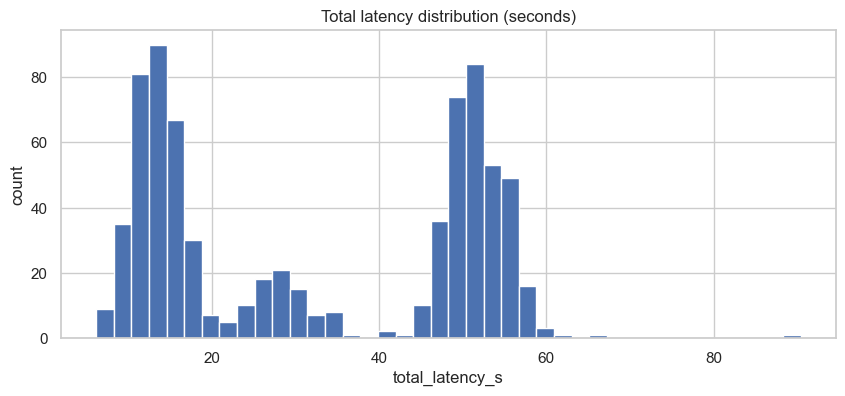

C:\Users\Jules\AppData\Local\Temp\ipykernel_4916\3295347622.py:103: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([grounded, halluc], labels=['grounded','hallucinated'], showfliers=False)


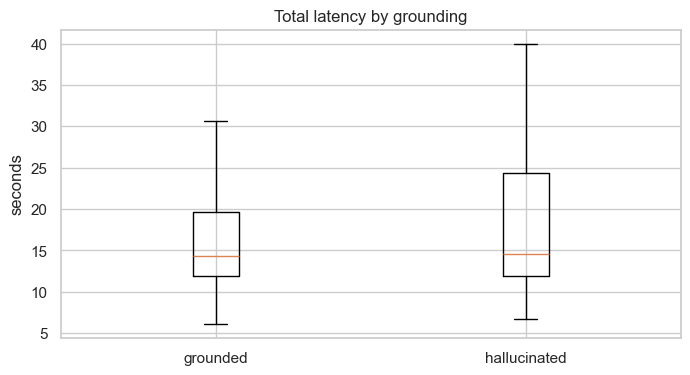

C:\Users\Jules\AppData\Local\Temp\ipykernel_4916\3295347622.py:114: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([succ, fail], labels=['success','failure'], showfliers=False)


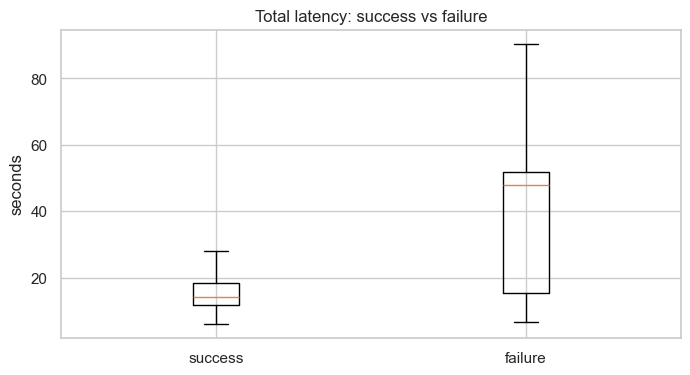

Avg query latency: 10.56s | Avg grading latency: 21.78s


In [5]:
from pathlib import Path
import csv
import re
from datetime import datetime
import matplotlib.pyplot as plt

exp_dir = Path('rag_eval/evals/experiments')
csv_files = sorted(exp_dir.glob('*.csv'), key=lambda p: p.stat().st_mtime, reverse=True)
if not csv_files:
    raise FileNotFoundError(f'No CSV files found in {exp_dir.resolve()}')

print('Found CSV runs:')
for f in csv_files[:10]:
    print(' -', f.name)

def load_rows_csv(path: Path):
    with path.open(encoding='utf-8', newline='') as fh:
        reader = csv.DictReader(fh)
        return list(reader)

def to_float(x):
    try:
        return float(x)
    except Exception:
        return None

def compute_success(row):
    return (
        (row.get('grounding') == 'grounded')
        and (row.get('faithfulness') == 'faithful')
        and (row.get('coverage') in ('high', 'partial'))
    )

def parse_timestamp_from_logfile(log_file: str):
    # Supports log names like: graph_rag_eval_2026-01-03T14-18-01.205299.json
    m = re.search(r'graph_rag_eval_(\d{4}-\d{2}-\d{2}T\d{2}-\d{2}-\d{2}\.\d+)\.json', log_file)
    if not m:
        return None
    ts = m.group(1)
    # Convert 2026-01-03T14-18-01.205299 -> 2026-01-03T14:18:01.205299
    ts = ts.replace('T', 'T').replace('-', ':', 2)  # only fixes first two '-' after the T
    # safer manual rebuild:
    ts = ts[:10] + 'T' + ts[11:13] + ':' + ts[14:16] + ':' + ts[17:]
    try:
        return datetime.fromisoformat(ts)
    except Exception:
        return None

def extract_latency_series(rows):
    # Prefer real latency columns if present
    has_total = any('total_latency_s' in r for r in rows)
    if has_total:
        total = [to_float(r.get('total_latency_s')) for r in rows]
        query = [to_float(r.get('query_latency_s')) for r in rows]
        grade = [to_float(r.get('grade_latency_s')) for r in rows]
        total = [x for x in total if x is not None]
        query = [x for x in query if x is not None]
        grade = [x for x in grade if x is not None]
        return {'mode': 'latency', 'total': total, 'query': query, 'grade': grade}

    # Fallback: throughput proxy using log filename timestamps (not true per-request latency under concurrency)
    times = []
    for r in rows:
        lf = (r.get('log_file') or '').strip()
        t = parse_timestamp_from_logfile(lf)
        if t is not None:
            times.append(t)
    times.sort()
    deltas = []
    for i in range(1, len(times)):
        deltas.append((times[i] - times[i-1]).total_seconds())
    return {'mode': 'throughput_proxy', 'deltas': deltas}

def percentile(xs, p):
    xs = sorted(xs)
    if not xs:
        return None
    k = int(round((p/100) * (len(xs)-1)))
    return xs[min(max(k,0), len(xs)-1)]

# --- Plot newest run in detail ---
newest = csv_files[0]
rows = load_rows_csv(newest)
series = extract_latency_series(rows)
print('\nUsing newest run:', newest.name)

if series['mode'] == 'latency':
    total = series['total']
    print(f'Total latency: n={len(total)} median={percentile(total,50):.2f}s p90={percentile(total,90):.2f}s')
    plt.figure(figsize=(10,4))
    plt.hist(total, bins=40)
    plt.title('Total latency distribution (seconds)')
    plt.xlabel('total_latency_s')
    plt.ylabel('count')
    plt.show()

    # Compare latency by grounded vs hallucinated
    grounded = [to_float(r.get('total_latency_s')) for r in rows if r.get('grounding') == 'grounded']
    halluc = [to_float(r.get('total_latency_s')) for r in rows if r.get('grounding') == 'hallucinated']
    grounded = [x for x in grounded if x is not None]
    halluc = [x for x in halluc if x is not None]
    plt.figure(figsize=(8,4))
    plt.boxplot([grounded, halluc], labels=['grounded','hallucinated'], showfliers=False)
    plt.title('Total latency by grounding')
    plt.ylabel('seconds')
    plt.show()

    # Compare success vs failure
    succ = [to_float(r.get('total_latency_s')) for r in rows if compute_success(r)]
    fail = [to_float(r.get('total_latency_s')) for r in rows if not compute_success(r)]
    succ = [x for x in succ if x is not None]
    fail = [x for x in fail if x is not None]
    plt.figure(figsize=(8,4))
    plt.boxplot([succ, fail], labels=['success','failure'], showfliers=False)
    plt.title('Total latency: success vs failure')
    plt.ylabel('seconds')
    plt.show()

    # Query vs grading contribution (mean)
    q = series['query']
    g = series['grade']
    if q and g:
        print(f'Avg query latency: {sum(q)/len(q):.2f}s | Avg grading latency: {sum(g)/len(g):.2f}s')
else:
    deltas = series['deltas']
    print('No latency columns found. Plotting throughput proxy (time between completed requests).')
    if deltas:
        print(f'Proxy spacing: n={len(deltas)} median={percentile(deltas,50):.2f}s p90={percentile(deltas,90):.2f}s')
        plt.figure(figsize=(10,4))
        plt.hist(deltas, bins=40)
        plt.title('Throughput proxy: time between completions (seconds)')
        plt.xlabel('seconds between completed requests')
        plt.ylabel('count')
        plt.show()
    print('To get true per-question latency, rerun rag_eval/evals.py with the latest code so it writes total_latency_s/query_latency_s/grade_latency_s.')

C:\Users\Jules\AppData\Local\Temp\ipykernel_4916\1299802298.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([q, g], labels=['Query (response)', 'Grading'], showfliers=False)


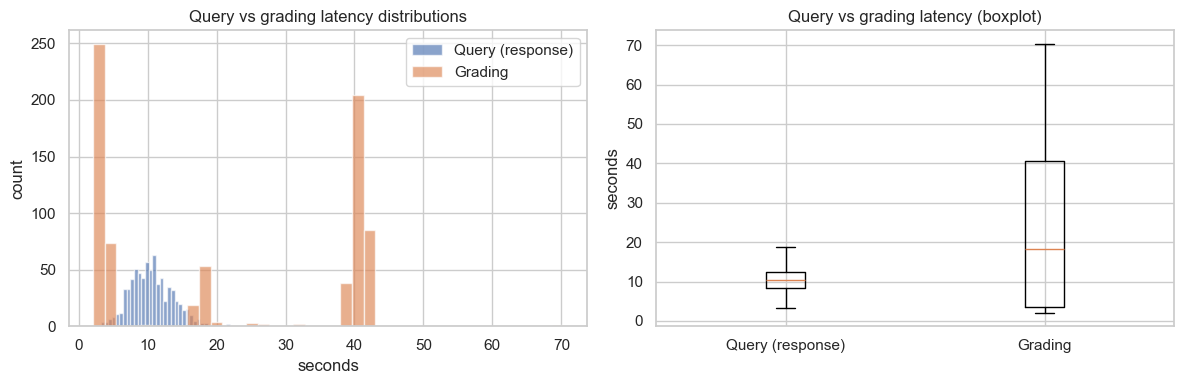

In [6]:
# Query (response) vs Grading latency plots
# Uses `series` computed in the previous cell (prefers true latency columns when present).
if 'series' not in globals() or series.get('mode') != 'latency':
    print('Latency columns not available for this run; cannot plot query vs grading latency.')
else:
    q = series.get('query', [])
    g = series.get('grade', [])
    if not q or not g:
        print('Missing query_latency_s and/or grade_latency_s values.')
    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # 1) Distribution overlay
        axes[0].hist(q, bins=40, alpha=0.65, label='Query (response)')
        axes[0].hist(g, bins=40, alpha=0.65, label='Grading')
        axes[0].set_title('Query vs grading latency distributions')
        axes[0].set_xlabel('seconds')
        axes[0].set_ylabel('count')
        axes[0].legend()

        # 2) Boxplot comparison (robust to outliers)
        axes[1].boxplot([q, g], labels=['Query (response)', 'Grading'], showfliers=False)
        axes[1].set_title('Query vs grading latency (boxplot)')
        axes[1].set_ylabel('seconds')

        plt.tight_layout()
        plt.show()

**Summary (this run, n=735):**
- Median total latency: **28.78s**
- P90 total latency: **54.50s**
- Mean breakdown: **10.56s query** + **21.78s grading** (grading dominates)

**"Query vs grading" plot:**
- The blue distribution (query/response generation) is fairly concentrated around ~10s, with a modest tail which is really a reasonable time.
- The orange distribution (grading) is much wider and drives most of the end-to-end variance (the boxplot shows a much larger IQR and higher upper whisker).
- We can also those 3 peaks in the total distribution plot. Is it caused by the retries. At a first glance, we can roughly say that 50% of the grading was done in one tries (around 4sec), 10% with one try (around 18sec) and the 40% left corresponding to the unknown failed after 3 tries (around 40sec)

**What the plots suggest:**
- The histogram shows **a wide spread** with a long tail: most questions complete in a few tens of seconds, but a non-trivial fraction take close to a minute (or more).
- **Grounded vs hallucinated**: the hallucinated boxplot has a higher upper range, suggesting hallucinated cases can be slower (often because the model keeps generating longer, unsupported text, and/or because grading is harder).
- **Success vs failure**: failures are dramatically slower than successes in this run. A common explanation is that failures include harder questions (more context/evidence) and/or trigger retries/backoff due to local-host overload or empty responses.

**Caveats / how to read this correctly:**
- These are **end-to-end evaluation latencies** measured on one machine. They depend heavily on local hardware and current load.
- Concurrency and VRAM pressure can create tail latency (rare slow outliers). This is also related to the `unknown` grading issue: stabilizing the grader often increases runtime but reduces empty outputs.

**Takeaway:** most of the time cost is in grading; improving grader stability/efficiency (or lowering grading concurrency while accepting longer runs) is the highest-leverage way to reduce tail latency and improve metric coverage.

##  [&#9650;](#toc0_) <a id='toc3_2_'></a>Conclusion

What we can conclude from this final run

**1) The evaluation has limited coverage (many `unknown` labels).**<br>
A major limitation is the **high rate of `unknown` labels** produced by the grader for several metrics: Coverage 40.1%, Grounding 45.2%, Faithfulness 47.6%, Answer relevancy 50.2%. `Unknown` usually happens when the grader output is empty/malformed (often due to local-host overload) or cannot be parsed into the allowed labels.<br>
Because the Metrics plot filters out `unknown`, it should be interpreted as **the distribution among successfully graded rows**, not the whole dataset.

**2) On the graded subset, reliability is still a concern.**<br>
Even before accounting for `unknown`, the model shows a tendency to generate unsupported content:
- **Grounding**: 30.2% hallucinated vs 24.6% grounded (45.2% unknown).
- **Faithfulness**: 27.8% unfaithful vs 24.6% faithful (47.6% unknown).
- **Coverage**: low coverage is common (29.5% low; only 30.3% high+partial; 40.1% unknown).
This matches the failure examples where answers look plausible but are not tied to the retrieved evidence.

**3) The overall success rate is low.**<br>
The pipeline achieves **23.3% high success rate**.<br>
In addition, we detected **194 critical failures** (hallucinated + low coverage), which represent 26.4%.

**4) Style likely contributes to errors.**<br>
The model is usually verbose (63.9% verbose, 35.2% concise, 0.8% terse). Verbosity can make hallucinations worse because the model continues generating text after it has exhausted retrieved facts.

**5) Harder evidence cases are where the pipeline breaks most.**<br>
In the evidence complexity analysis, failed answers tend to be associated with higher triple counts (avg ~0.85 failed vs ~0.17 successful). This suggests the pipeline struggles more when the answer requires combining more evidence.

**6) Performance / latency takeaway.**<br>
For this run (n=735), end-to-end latency is **median 28.78s** (p90 54.50s). The mean split is **10.56s query** vs **21.78s grading**, so **grading dominates** and explains most of the tail latency.

#### What we cannot conclude confidently
- We cannot reliably estimate true grounding/faithfulness/coverage across all questions because ~40–50% of rows are `unknown` for those metrics.
- If `unknown` is correlated with harder questions (or overload), the visible distribution could be biased.

#### Most justified next improvements
- **Stabilize grading first**: reduce grading concurrency further and/or increase backoff so `unknown` drops (otherwise comparisons are noisy).
- **Constrain generation**: enforce shorter answers and require citing evidence (reduce unsupported filler).
- **Improve retrieval/selection**: tune source selection (and consider fewer sources if each question typically needs one) to reduce distraction and off-topic continuations.

Overall: the benchmark indicates the pipeline can answer some questions correctly, but it is not consistently grounded or complete yet, and the evaluation itself is partially blind due to the `unknown` rate and hardware limits.